### Importing packages

In [813]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr
from scipy.ndimage import gaussian_filter

from helpers import *
import cca_helpers

### Loading Data

In [814]:
data_path = r"C:\Users\alex.legariamacal\Downloads\fwcajalproject"

data_path =  '../data/'

trial_inf = trial_info(data_path + r"ab042_trial_data.csv")
neuron_inf = neuron_info(data_path + r"ab042_cluster_spike_times.csv")
spike_array = np.load(data_path + r"ab042_spikes_dense.npy")

In [815]:
print(f"Trial types: {trial_inf.trial_types}")
print(f"Areas: {neuron_inf.areas}")


Trial types: ['Auditory Hit', 'Auditory Miss', 'Whisker Hit', 'Whisker Miss', 'False Alarm', 'Correct Rejection']
Areas: ['OFC' 'wM2' 'Thalamus' 'DS' 'wS1' 'nS1' 'DLS' 'tjM1']


In [816]:
trial_type = ["Auditory Hit"]
trial_conditions = ['Auditory Hit']
area_1 = "wM2"
area_2 = "tjM1"

area1_spikes = []
area2_spikes = []

trial_indices = []

for trial_type in trial_conditions:
    
    trial_indices.append(trial_inf.trial_index[trial_type])
    
    trial_type = [trial_type]    
    
    area1_spikes_t = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_1]
    area2_spikes_t = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_2]
    area1_spikes.append(area1_spikes_t)
    area2_spikes.append(area2_spikes_t)

area1_spikes = np.concatenate(area1_spikes, axis=1)
area2_spikes = np.concatenate(area2_spikes, axis=1)

#trial_indices = np.concatenate(trial_indices)
print(area1_spikes.shape, area2_spikes.shape)


(126, 83, 401) (166, 83, 401)


In [817]:
#Here we slice the array and we smooth

pre_win = 0
post_win = 100

kernel_size = 5


proc_area_1_data = slice_array(area1_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)
proc_area_2_data = slice_array(area2_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)

print(proc_area_1_data.shape)
print(proc_area_2_data.shape)


(126, 83, 100)
(166, 83, 100)


#### Residuals

In [818]:

proc_area_1 = proc_area_1_data - np.mean(proc_area_1_data,axis=1)[:,None,:]
proc_area_2 = proc_area_2_data - np.mean(proc_area_2_data,axis=1)[:,None,:]


In [819]:
area1_tr, area1_te, idx_tr, idx_te = split_reshape(proc_area_1, trial_indices)
data1_tr = np.asarray(proc_area_1_data[:,idx_tr[0],:])
data1_tr = data1_tr.reshape(data1_tr.shape[0], -1)
data1_te = np.asarray(proc_area_1_data[:,idx_te[0],:])
data1_te = data1_te.reshape(data1_te.shape[0], -1)

print(area1_tr.shape, data1_tr.shape)
print(area1_te.shape, data1_te.shape)


area2_tr, area2_te, idx_tr, idx_te = split_reshape(proc_area_2, trial_indices)
data2_tr = np.asarray(proc_area_2_data[:,idx_tr[0],:])
data2_tr = data2_tr.reshape(data2_tr.shape[0], -1)
data2_te = proc_area_2_data[:,idx_te[0],:]
data2_te = data2_te.reshape(data2_te.shape[0], -1)

print(area2_tr.shape, data2_tr.shape)
print(area2_te.shape, data2_te.shape)


n_trials = int(proc_area_1.shape[1]//2) #n_trials per train or test

print(n_trials)

ids_te, trial_ids_te = idx_te[0], idx_te[1]

# Keep trial conditions trials
idx_te_type_1 = [idx for idx,i in enumerate(ids_te) if trial_ids_te[idx] in trial_indices[0]]
#idx_te_type_2 = [idx for idx,i in enumerate(ids_te) if trial_ids_te[idx] in trial_indices[1]]
#print(idx_te_type_1, idx_te_type_2)
#print(len(idx_te_type_1), len(idx_te_type_2))

(126, 4100) (126, 4100)
(126, 4100) (126, 4100)
(166, 4100) (166, 4100)
(166, 4100) (166, 4100)
41


In [820]:
print(f"Area1 train: {area1_tr.shape}, Area1 test: {area1_te.shape}")
print(f"Area2 train: {area2_tr.shape}, Area2 test: {area2_te.shape}")

Area1 train: (126, 4100), Area1 test: (126, 4100)
Area2 train: (166, 4100), Area2 test: (166, 4100)


In [821]:
#Here we mean center the data

X1_tr = area1_tr - area1_tr.mean(axis=1)[:,np.newaxis]
X1_te = area1_te - area1_tr.mean(axis=1)[:,np.newaxis]
X2_tr = area2_tr - area2_tr.mean(axis=1)[:,np.newaxis]
X2_te = area2_te - area2_tr.mean(axis=1)[:,np.newaxis]


data1_tr = data1_tr - data1_tr.mean(axis=1)[:,np.newaxis]
data2_tr = data2_tr - data2_tr.mean(axis=1)[:,np.newaxis]
data1_te = data1_te - data1_tr.mean(axis=1)[:,np.newaxis]
data2_te = data2_te - data2_tr.mean(axis=1)[:,np.newaxis]

print(X1_te.shape, X2_te.shape)
print(data1_tr.shape, data2_tr.shape)

(126, 4100) (166, 4100)
(126, 4100) (166, 4100)


### Getting ready for CCA

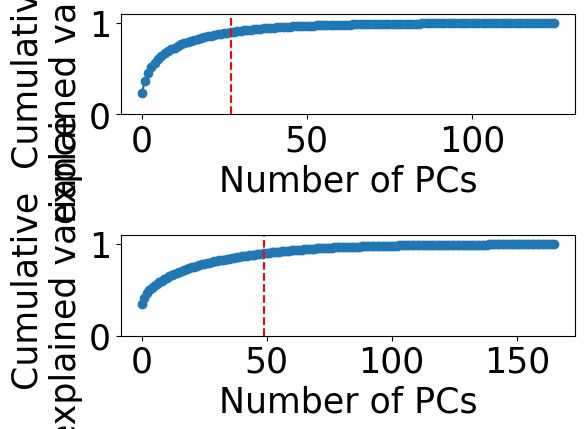

In [822]:
#Here we find the number of PCs that need to be kept

pca1 = PCA()
#pca1.fit(X1_tr.T)
#P_1_te = pca1.transform(X1_te.T)

pca1.fit(data1_tr.T)
P_1_te = pca1.transform(data1_te.T)

pca2 = PCA()
#pca2.fit(X2_tr.T)
#P_2_te = pca2.transform(X2_te.T)

pca2.fit(data2_tr.T)
P_2_te = pca2.transform(data2_te.T)


fig, axs = plt.subplots(2,1)
for ax in axs.flat:
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Cumulative \n explained variance')
    ax.set_xlabel('Number of PCs')
    
axs[0].plot(np.cumsum(pca1.explained_variance_ratio_), marker="o")
axs[0].axvline(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
axs[1].plot(np.cumsum(pca2.explained_variance_ratio_), marker="o")
axs[1].axvline(np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

plt.tight_layout()

c = max(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), 
               np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)))


### CCA 

In [823]:

data_axes_area_1, data_axes_area_2, data_A_1_tr, data_A_2_tr, cc = cca_helpers.align(data1_tr.T, data2_tr.T, m=c, cv=False)
data_A_1_te = data1_te.T @ data_axes_area_1
data_A_2_te = data2_te.T @ data_axes_area_2

print(data_A_1_te.shape, data_A_2_te.shape)


data_A_1_te_trials = data_A_1_te.reshape(n_trials, -1, data_A_1_te.shape[1])
data_A_2_te_trials = data_A_2_te.reshape(n_trials, -1, data_A_2_te.shape[1])


data_A_1_te_trials_t1 = np.mean(data_A_1_te_trials[idx_te_type_1] ,axis=0)
data_A_2_te_trials_t1 = np.mean(data_A_2_te_trials[idx_te_type_1] ,axis=0)


print(data_A_1_te_trials_t1.shape, data_A_2_te_trials_t1.shape)



data_1_trials_mean_t1_smooth = gaussian_filter(data_A_1_te_trials_t1, sigma=1, axes=(0))
data_2_trials_mean_t1_smooth = gaussian_filter(data_A_2_te_trials_t1, sigma=1, axes=(0))


print(data_1_trials_mean_t1_smooth.shape, data_2_trials_mean_t1_smooth.shape)


(4100, 49) (4100, 49)
(100, 49) (100, 49)
(100, 49) (100, 49)


### CCA on residuals

Input: (4100, 126) (4100, 166)
(4100, 126) (4100, 166)
(4100, 126) (4100, 166)
Output train (4100, 49) (4100, 49)
Output test (4100, 49) (4100, 49)
Post-align shapes:
Train (4100, 49) (4100, 49)
Test (4100, 49) (4100, 49)
Post-align reshape:
(41, 100, 49) (41, 100, 49)


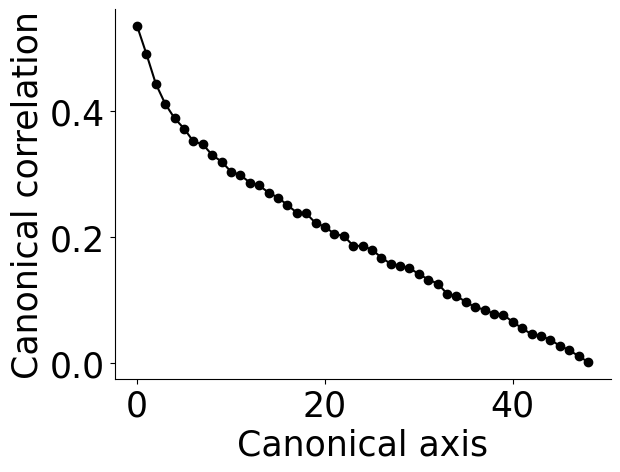

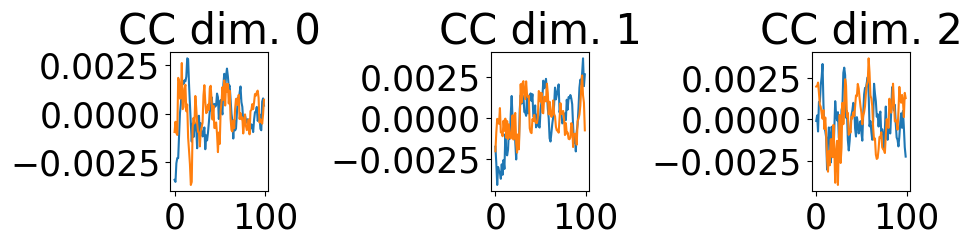

In [824]:


print('Input:', X1_tr.T.shape, X2_tr.T.shape)
axes_area_1, axes_area_2, A_1_tr, A_2_tr, cc = cca_helpers.align(X1_tr.T, X2_tr.T, m=c, cv=False)
cc = np.asarray(cc)
#print(axes_area_1.shape, axes_area_2.shape, A_1.shape, A_2.shape, cc.shape)

print(X1_te.T.shape, X2_te.T.shape)
A_1_te = X1_te.T @ axes_area_1
A_2_te = X2_te.T @ axes_area_2

print(data1_te.T.shape, data2_te.T.shape) #project data on axes based on residuals!
data_1_te = data1_te.T @ axes_area_1
data_2_te = data2_te.T @ axes_area_2

print('Output train', A_1_tr.shape, A_2_tr.shape)
print('Output test', A_1_te.shape, A_2_te.shape)

fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')


#A_1 = X_1.T @ axes_area_1
#A_2 = X_2.T @ axes_area_2
print('Post-align shapes:')
print('Train', A_1_tr.shape, A_2_tr.shape)
print('Test', A_1_te.shape, A_2_te.shape)

A_1_trials = A_1_tr.reshape(n_trials, -1, A_1_tr.shape[1])
A_2_trials = A_2_tr.reshape(n_trials, -1, A_2_tr.shape[1])

print('Post-align reshape:')
print(A_1_trials.shape, A_2_trials.shape)

fig, axs = plt.subplots(1,3, figsize=(10,3), sharex=False, sharey=False)
for cc_dim in range(3):
    axs[cc_dim].set_title('CC dim. {}'.format(cc_dim))
    axs[cc_dim].plot(np.mean(A_1_trials, axis=0)[:,cc_dim])
    axs[cc_dim].plot(np.mean(A_2_trials, axis=0)[:,cc_dim])
plt.tight_layout()

### Compare trial-averaged trajectories between areas
- Comparing PCA (unaligned axes) and CCA (aligned axes)

In [825]:
P_1_trials = P_1_te.reshape(n_trials, -1, P_1_te.shape[1])
P_2_trials = P_2_te.reshape(n_trials, -1, P_2_te.shape[1])
P_1_trials_mean_t1 = np.mean(P_1_trials[idx_te_type_1] ,axis=0)
P_2_trials_mean_t1 = np.mean(P_2_trials[idx_te_type_1] ,axis=0)

print(P_1_trials_mean_t1.shape, P_2_trials_mean_t1.shape)

A_1_trials = A_1_te.reshape(n_trials, -1, A_1_te.shape[1])
A_2_trials = A_2_te.reshape(n_trials, -1, A_2_te.shape[1])
A_1_trials_mean_t1 = np.mean(A_1_trials[idx_te_type_1] ,axis=0)
A_2_trials_mean_t1 = np.mean(A_2_trials[idx_te_type_1] ,axis=0)



data_1_te_trials = data_1_te.reshape(n_trials, -1, data_1_te.shape[1])
data_2_te_trials = data_2_te.reshape(n_trials, -1, data_2_te.shape[1])
data_1_trials_mean_t1 = np.mean(data_1_te_trials[idx_te_type_1] ,axis=0)
data_2_trials_mean_t1 = np.mean(data_2_te_trials[idx_te_type_1] ,axis=0)

print(data_1_trials_mean_t1.shape, data_2_trials_mean_t1.shape)

(100, 126) (100, 166)
(100, 49) (100, 49)


In [826]:
print(P_1_trials_mean_t1.shape)
print(P_2_trials_mean_t1.shape)
print(A_1_trials_mean_t1.shape)
print(A_2_trials_mean_t1.shape)
print(data_1_trials_mean_t1.shape)
print(data_2_trials_mean_t1.shape)

(100, 126)
(100, 166)
(100, 49)
(100, 49)
(100, 49)
(100, 49)


/var/folders/vr/p3nztt9d26q4905fqmd3ljw00000gq/T/ipykernel_20268/3512002503.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


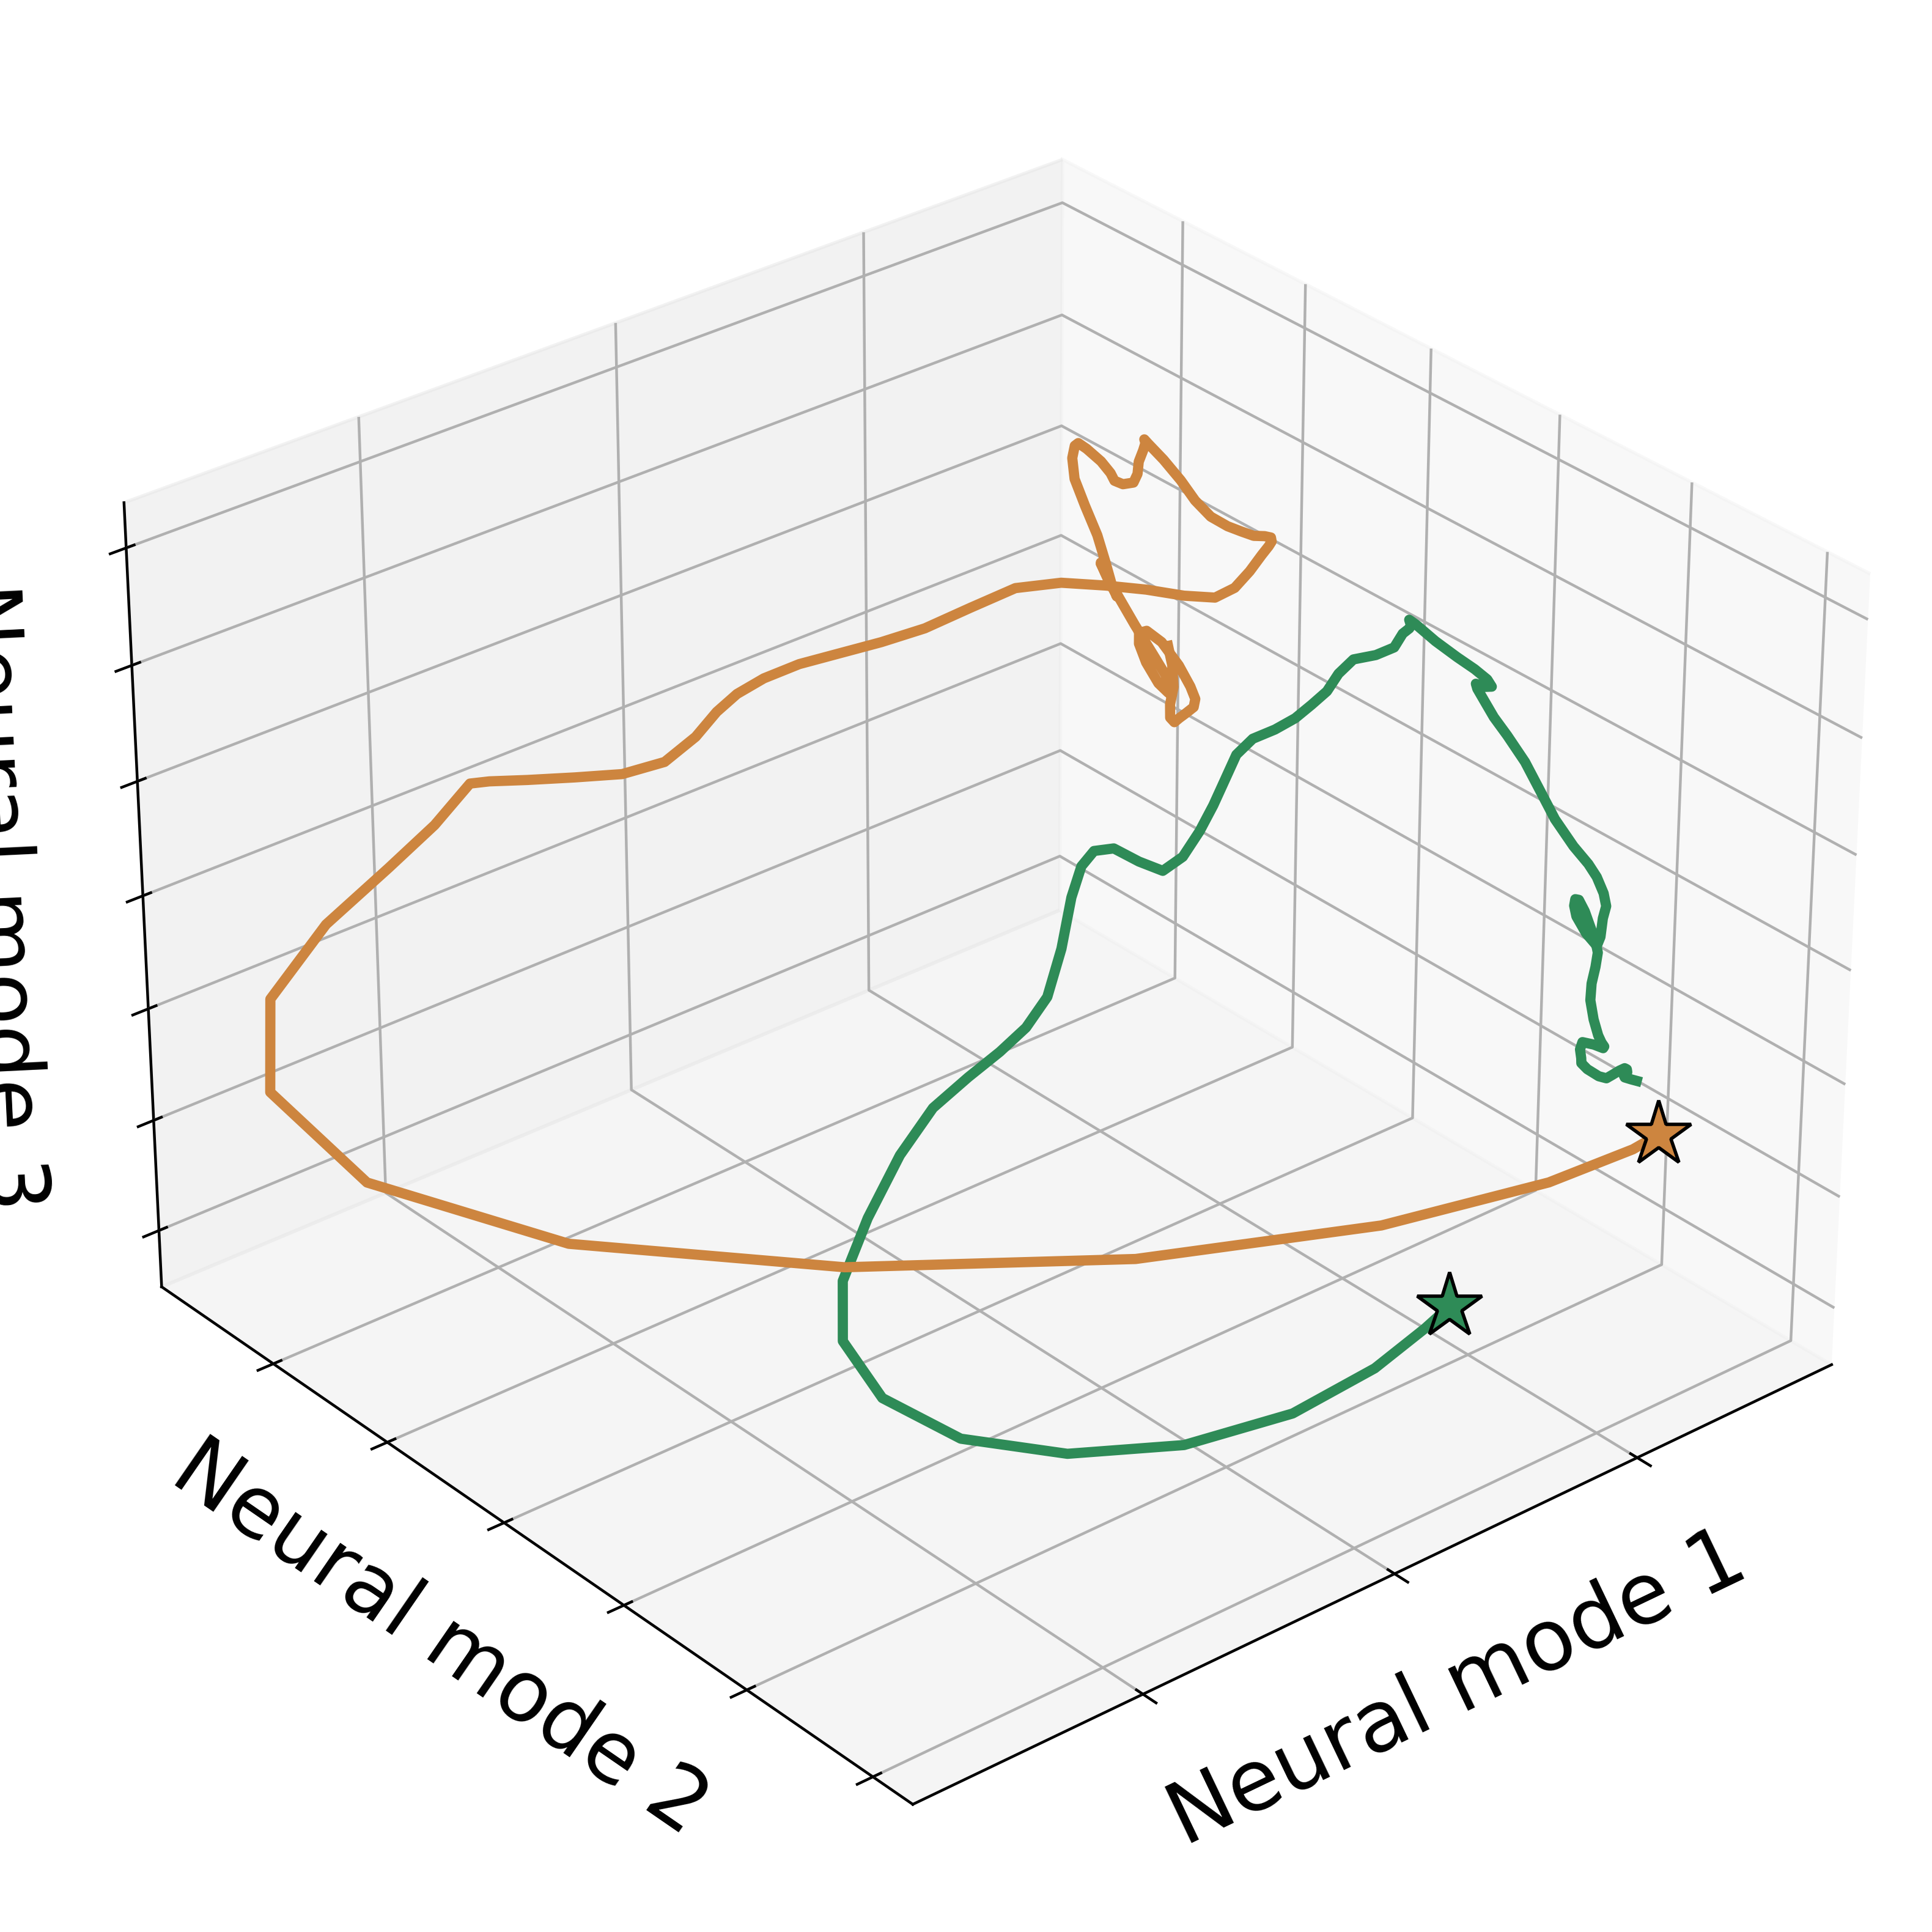

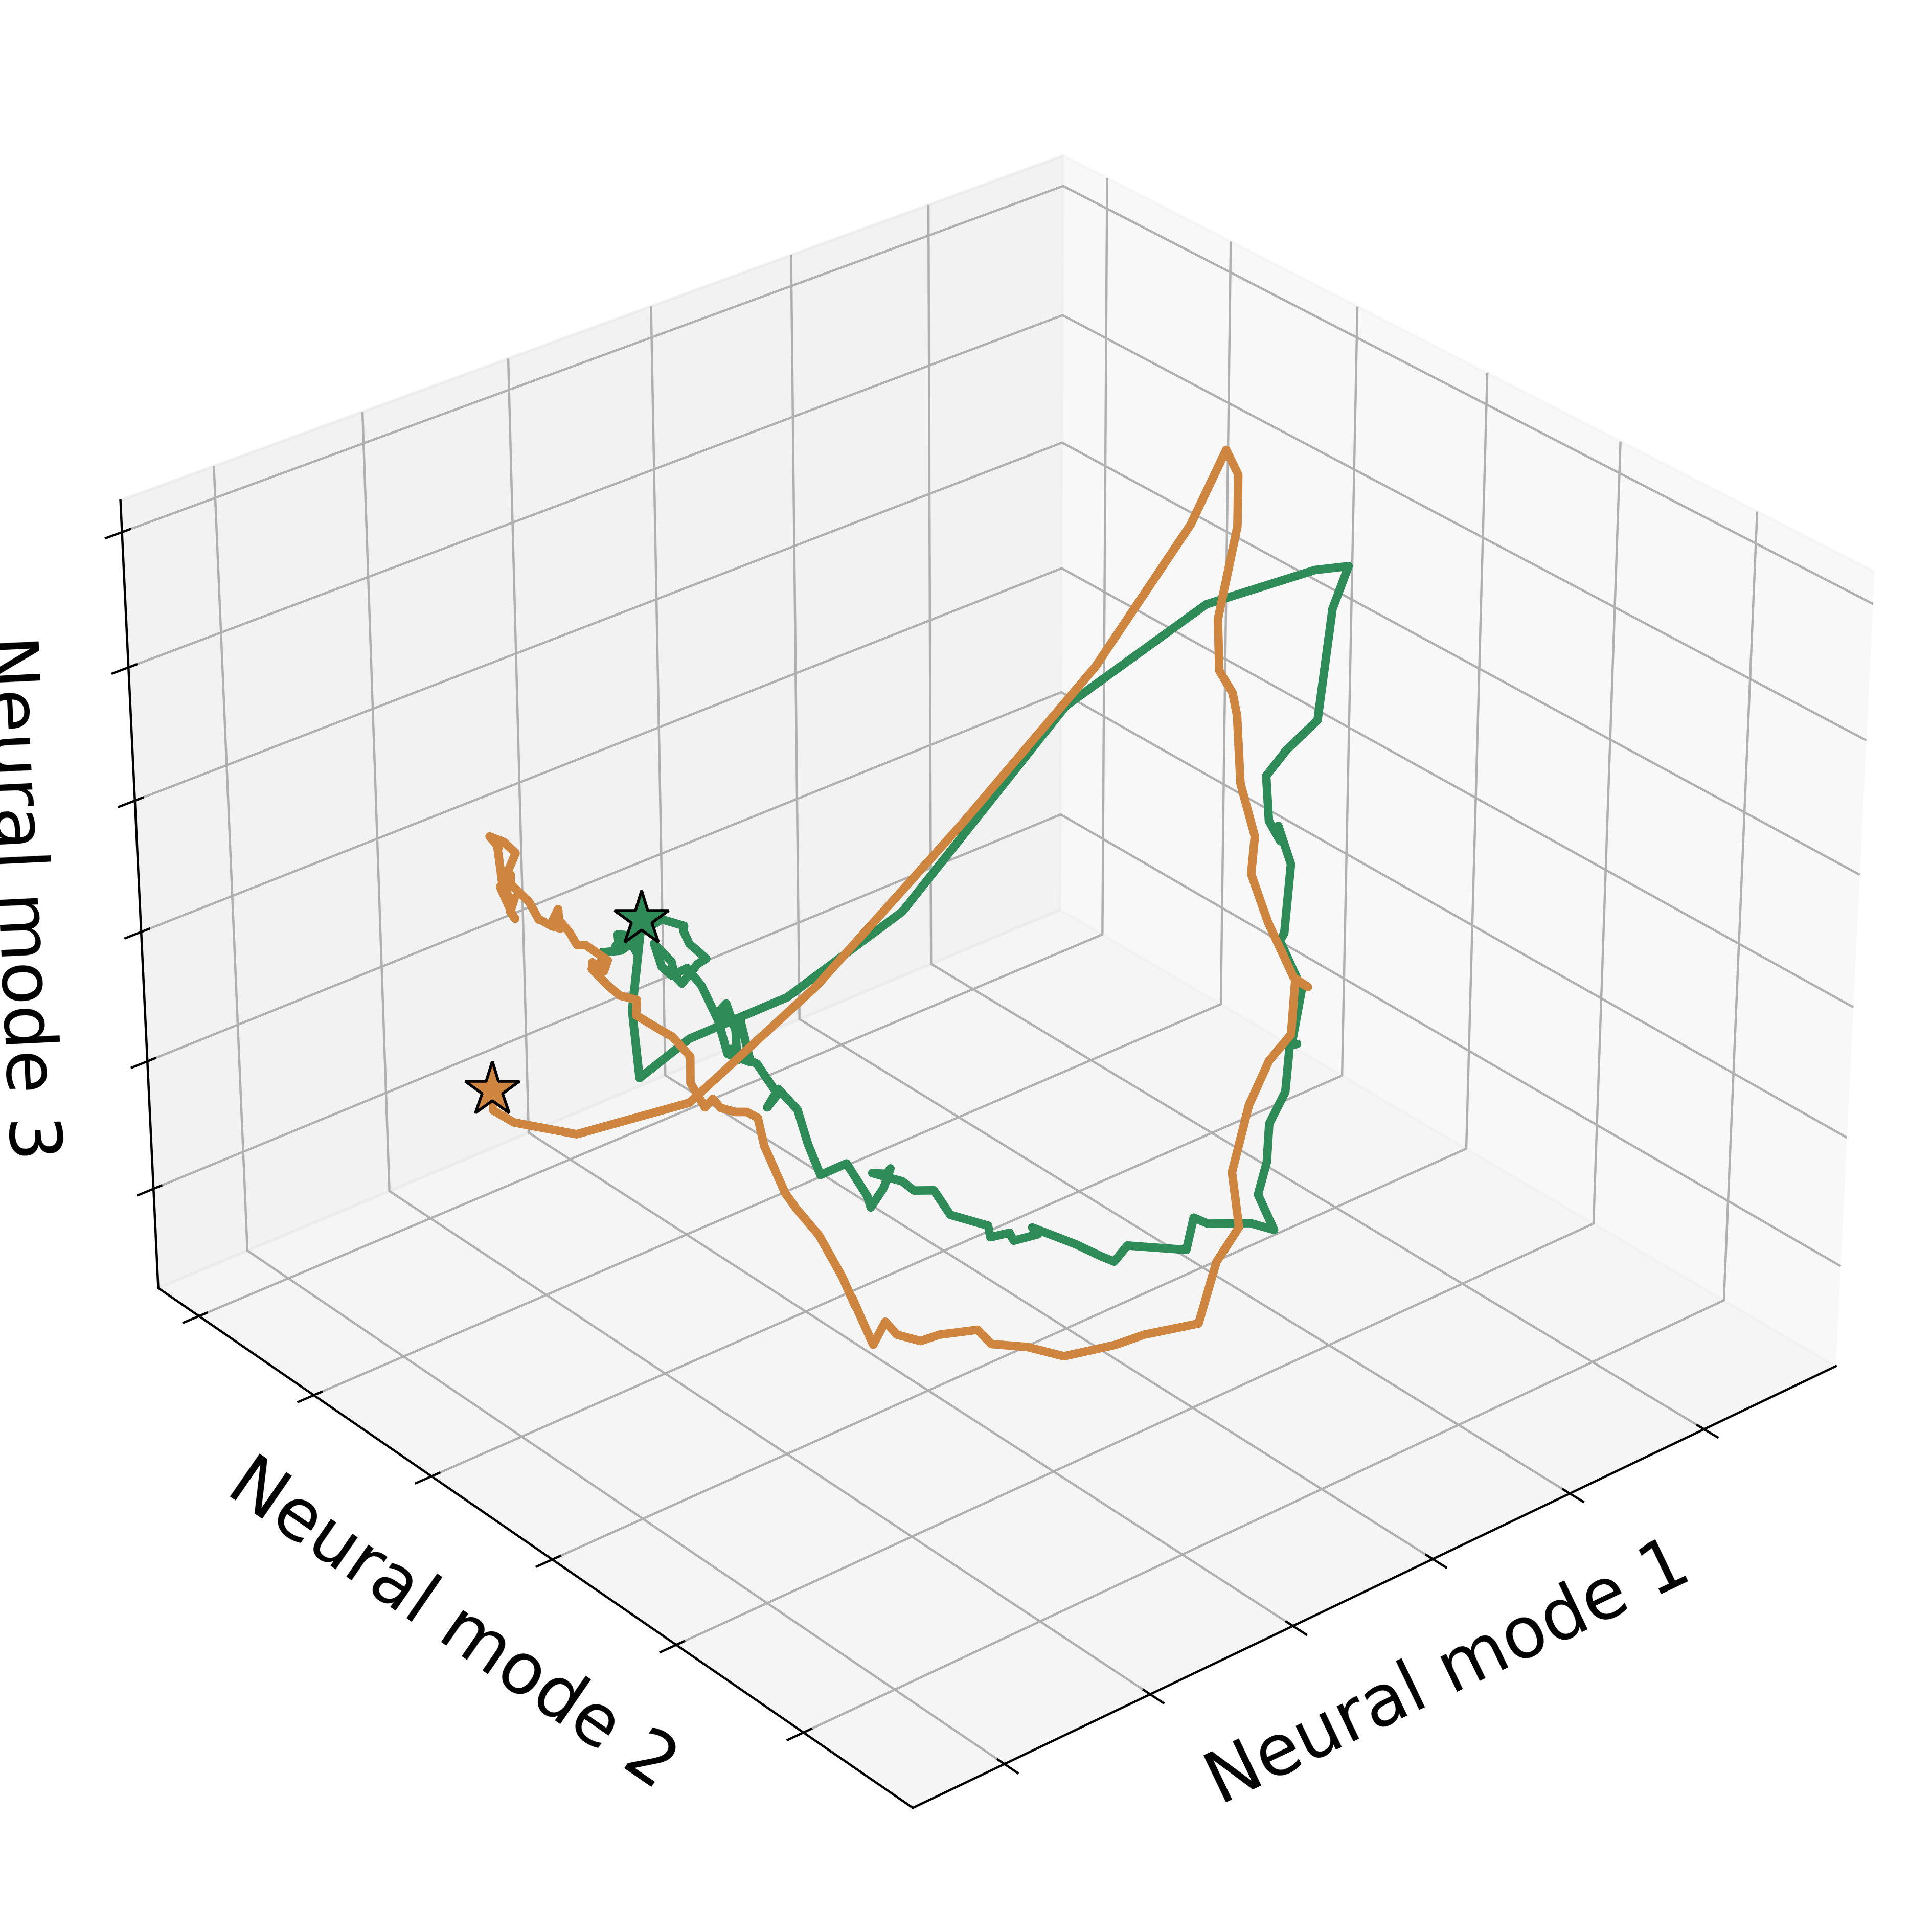

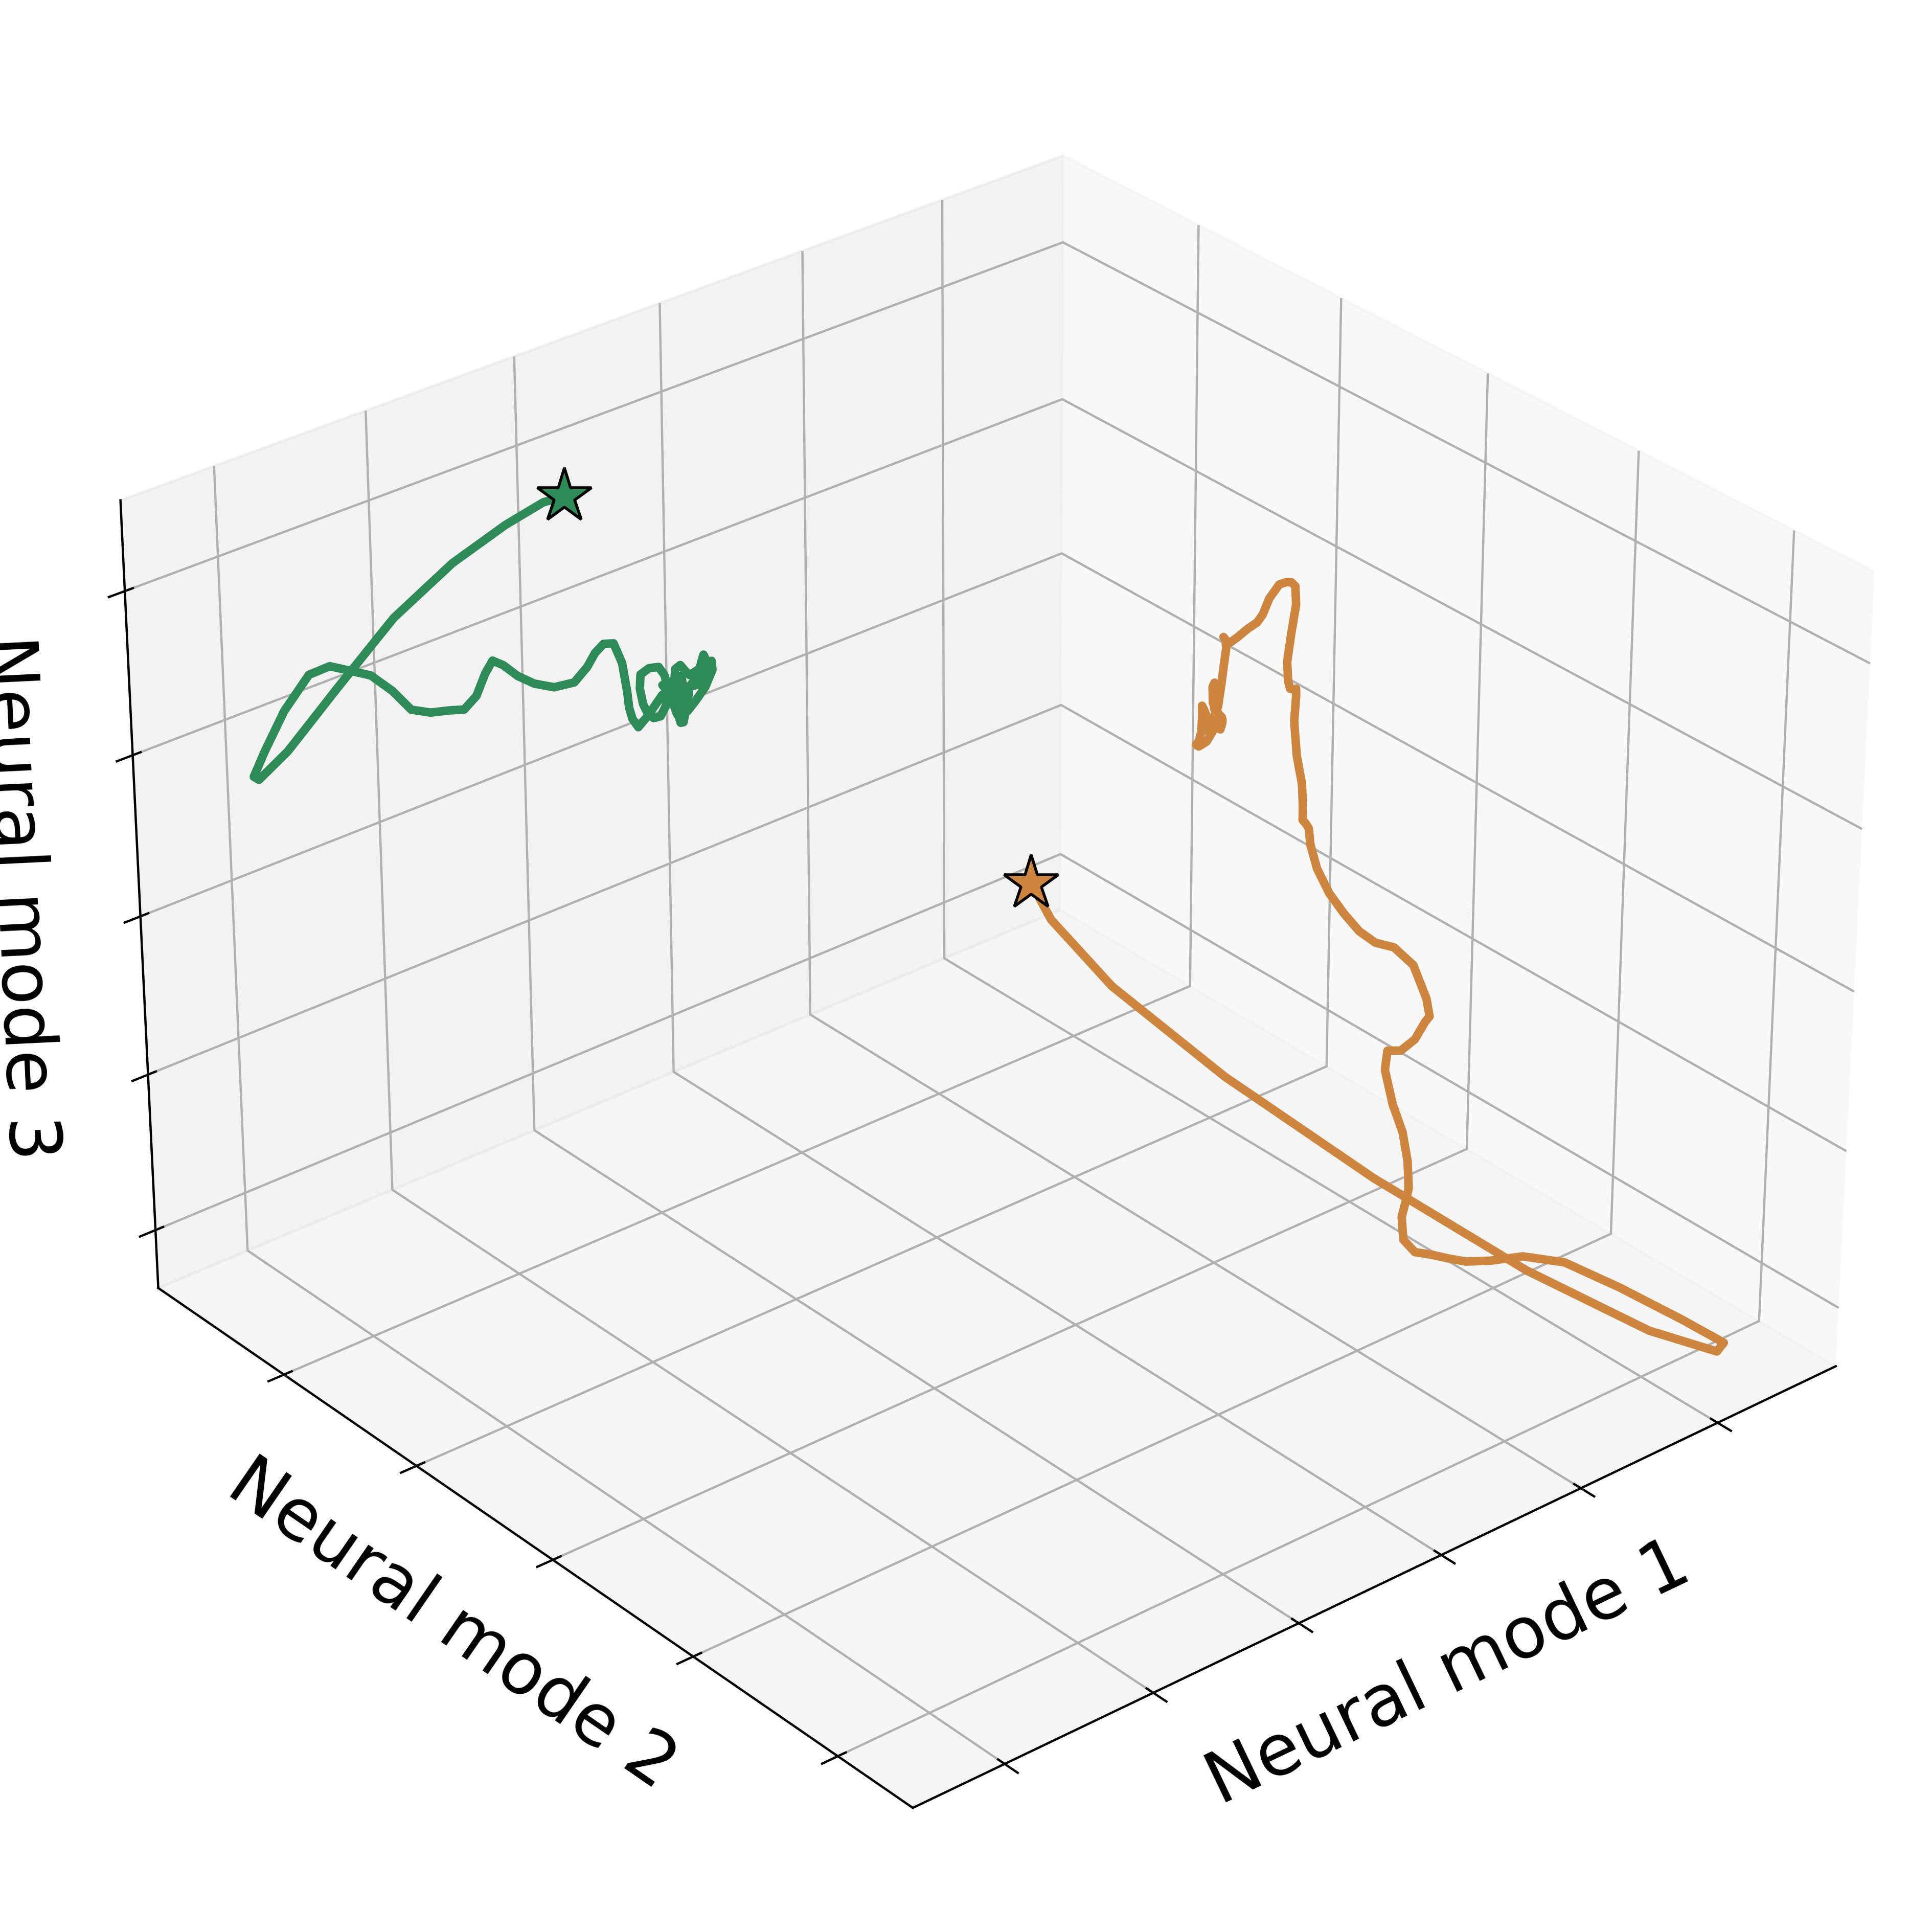

In [827]:
plt.rcParams.update({'font.size': 25})

# First smooth data

P_1_trials_mean_t1_smooth = gaussian_filter(P_1_trials_mean_t1, sigma=1, axes=(0))
P_2_trials_mean_t1_smooth = gaussian_filter(P_2_trials_mean_t1, sigma=1, axes=(0))

A_1_trials_mean_t1_smooth = gaussian_filter(A_1_trials_mean_t1, sigma=1, axes=(0))
A_2_trials_mean_t1_smooth = gaussian_filter(A_2_trials_mean_t1, sigma=1, axes=(0))

data_1_trials_mean_t1_smooth = gaussian_filter(data_1_trials_mean_t1, sigma=1, axes=(0))
data_2_trials_mean_t1_smooth = gaussian_filter(data_2_trials_mean_t1, sigma=1, axes=(0))


res_dpi = 400
figsize = (10,10)

# Plot
fig, axs = plt.subplots(1,1, figsize=figsize, dpi=res_dpi, subplot_kw={'projection': '3d'})

lw = 3

#for ax in axs.flat:
axs.set_xlabel('Neural mode 1')
axs.set_ylabel('Neural mode 2')
axs.set_zlabel('Neural mode 3')
axs.set_xticklabels([])
axs.set_yticklabels([])
axs.set_zticklabels([])
remove_top_right_frame(axs)
axs.view_init(elev=-150, azim=130)
    

# Trajectories of trial-averages
axs.plot(P_1_trials_mean_t1_smooth[:,0], 
          P_1_trials_mean_t1_smooth[:,1], 
          P_1_trials_mean_t1_smooth[:,2],
          color = get_area_color(area_1),
             lw=lw)


axs.plot(P_2_trials_mean_t1_smooth[:,0], 
          P_2_trials_mean_t1_smooth[:,1], 
          P_2_trials_mean_t1_smooth[:,2],
          color = get_area_color(area_2),
             lw=lw)


# Starting points
axs.plot(P_1_trials_mean_t1_smooth[0,0], 
          P_1_trials_mean_t1_smooth[0,1], 
          P_1_trials_mean_t1_smooth[0,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)

axs.plot(P_2_trials_mean_t1_smooth[0,0], 
          P_2_trials_mean_t1_smooth[0,1], 
          P_2_trials_mean_t1_smooth[0,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)

fig.tight_layout()
# Save figure
figure_path =  '../figures_final'
elts = trial_type[0].split(' ')
init1=elts[0][0].upper()
init2=elts[1][0].upper()
fname = 'pca_data_{}_{}_{}{}_smooth'.format(area_1, area_2, init1, init2)
fig.savefig(os.path.join(figure_path,fname), format='figure')

# CCA
fig, axs = plt.subplots(1,1, figsize=figsize, dpi=res_dpi, subplot_kw={'projection': '3d'})

lw = 3

#for ax in axs.flat:
axs.set_xlabel('Neural mode 1')
axs.set_ylabel('Neural mode 2')
axs.set_zlabel('Neural mode 3')
axs.set_xticklabels([])
axs.set_yticklabels([])
axs.set_zticklabels([])
remove_top_right_frame(axs)
axs.view_init(elev=-150, azim=130)


# Trajectories of trial-averages
axs.plot(data_A_1_te_trials_t1[:,0], 
          data_A_1_te_trials_t1[:,1], 
          data_A_1_te_trials_t1[:,2],
          color = get_area_color(area_1),
             lw=lw)


axs.plot(data_A_2_te_trials_t1[:,0], 
          data_A_2_te_trials_t1[:,1], 
          data_A_2_te_trials_t1[:,2],
          color = get_area_color(area_2),
             lw=lw)

# Starting points
axs.plot(data_A_1_te_trials_t1[0,0], 
          data_A_1_te_trials_t1[0,1], 
          data_A_1_te_trials_t1[0,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)


axs.plot(data_A_2_te_trials_t1[0,0], 
          data_A_2_te_trials_t1[0,1], 
          data_A_2_te_trials_t1[0,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)


fig.tight_layout()

# Save figure
figure_path =  '../figures_final'
elts = trial_type[0].split(' ')
init1=elts[0][0].upper()
init2=elts[1][0].upper()
fname = 'cca_data_{}_{}_{}{}_smooth'.format(area_1, area_2, init1, init2)
fig.savefig(os.path.join(figure_path,fname), format='figure')

# CCA on residuals
fig, axs = plt.subplots(1,1, figsize=figsize, dpi=res_dpi, subplot_kw={'projection': '3d'})

axs.set_xlabel('Neural mode 1')
axs.set_ylabel('Neural mode 2')
axs.set_zlabel('Neural mode 3')
axs.set_xticklabels([])
axs.set_yticklabels([])
axs.set_zticklabels([])
remove_top_right_frame(axs)
axs.view_init(elev=-150, azim=130)


# Trajectories of trial-averages
axs.plot(data_1_trials_mean_t1_smooth[:,0], 
          data_1_trials_mean_t1_smooth[:,1], 
          data_1_trials_mean_t1_smooth[:,2],
          color = get_area_color(area_1),
             lw=lw)

axs.plot(data_2_trials_mean_t1_smooth[:,0], 
          data_2_trials_mean_t1_smooth[:,1], 
          data_2_trials_mean_t1_smooth[:,2],
          color = get_area_color(area_2),
             lw=lw)

# Starting points
axs.plot(data_1_trials_mean_t1_smooth[0,0], 
          data_1_trials_mean_t1_smooth[0,1], 
          data_1_trials_mean_t1_smooth[0,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)


axs.plot(data_2_trials_mean_t1_smooth[0,0], 
          data_2_trials_mean_t1_smooth[0,1], 
          data_2_trials_mean_t1_smooth[0,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)


fig.tight_layout()

# Save figure
figure_path =  '../figures_final'
elts = trial_type[0].split(' ')
init1=elts[0][0].upper()
init2=elts[1][0].upper()
fname = 'cca_res_{}_{}_{}{}_smooth'.format(area_1, area_2, init1, init2)
fig.savefig(os.path.join(figure_path,fname), format='figure')

# TODO:
- check correlation in PC
- smaller window
- all trials together then align
- residuals ("if no alignment, no comm"...)

In [678]:
axs.get_zlim()

(-0.03146951841058762, 0.021753088967493287)